In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_plots_size_params(size):
    # Adapted from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    bigger = size * 1.2
    slightly_bigger = size * 1.1
    plt.rc('font', size=size)                        # controls default text sizes
    plt.rc('axes', titlesize=bigger)                 # fontsize of the axes title
    plt.rc('axes', labelsize=slightly_bigger)        # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('legend', fontsize=size)                  # legend fontsize
    plt.rc('figure', figsize=(0.75*size, size/2))    # size of figure
    return
set_plots_size_params(20)

In [3]:
def these_muts_chance(mutations, fitness_distribution):
    return np.product(np.power(fitness_distribution, mutations))


def poisson(mu, k):
    return math.exp(-mu) * (mu**k) / math.factorial(k)


def get_mutation_probs(mutation_rate, min_freq):
    probs = dict()
    for num_of_muts in range(20):
        prob = poisson(mutation_rate, num_of_muts)
        if prob <= min_freq:
            break
        probs[num_of_muts] = prob
    return probs


def get_mutations(mutation_rate, fitness_distribution, min_freq, max_mutations=20):
    possible_mutations = []
    for a1 in range(max_mutations+1):
        for a2 in range(max_mutations+1):
            for a3 in range(max_mutations+1):
                perm = (a1,a2,a3)
                if sum(perm)>max_mutations or perm in possible_mutations:
                    continue
                possible_mutations.append(perm)
    possible_mutations = tuple(possible_mutations)
    this_many_muts_chance = get_mutation_probs(mutation_rate, min_freq)
    mutations_prob = dict()
    for mut_tuple in possible_mutations:
        num_of_muts = sum(mut_tuple)
        if num_of_muts in this_many_muts_chance.keys():  
            mut_prob = this_many_muts_chance[num_of_muts] * these_muts_chance(mut_tuple, fitness_distribution)
            if mut_prob > min_freq:
                mutations_prob[mut_tuple] = mut_prob
    return mutations_prob

In [4]:
def normalize(array):
    return array / np.linalg.norm(array, ord=1)


def simulate_next_passage(fitness_values, genotype_freqs, mutation_probabilities, min_freq):
    new_freqs = genotype_freqs.copy()
    for genotype, freq in genotype_freqs.items():
        for mutation, mut_freq in mutation_probabilities.items():
            new_genotype = tuple(np.add(genotype, mutation).tolist())
            fitness = np.product(np.power(fitness_values, new_genotype))
            new_freq = freq * mut_freq * fitness
            if genotype == new_genotype:
                new_freqs[new_genotype] = new_freq
            else:
                if new_freq > min_freq:
                    if new_genotype not in new_freqs.keys():
                        new_freqs[new_genotype] = 0
                    new_freqs[new_genotype] += new_freq
    new_freqs = pd.Series(new_freqs)
    normalized = normalize(new_freqs)
    return normalized[normalized > min_freq]


def model(fitness_distribution, fitness_values, mutation_rate, passages, virions_num=10**10):
    passage = dict()
    passage[0] = {(0,0,0): 1}
    min_freq = 1/virions_num
    mutation_probabilities = get_mutations(mutation_rate, fitness_distribution, min_freq)
    for i in range(passages):
        passage[i+1] = simulate_next_passage(fitness_values, passage[i], mutation_probabilities, min_freq)
    return passage

<AxesSubplot:ylabel='Count'>

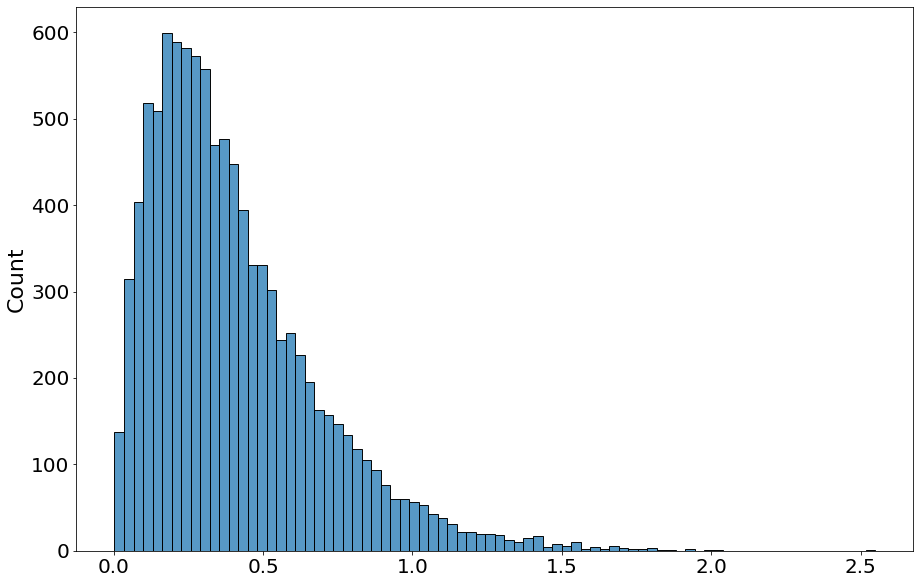

In [5]:
gamma_dist = np.random.gamma(2,0.2, 10000)
sns.histplot(gamma_dist)

In [6]:
get_mutation_probs(5, 1/10**10)

{0: 0.006737946999085467,
 1: 0.03368973499542734,
 2: 0.08422433748856833,
 3: 0.14037389581428056,
 4: 0.1754673697678507,
 5: 0.1754673697678507,
 6: 0.1462228081398756,
 7: 0.104444862957054,
 8: 0.06527803934815875,
 9: 0.03626557741564375,
 10: 0.01813278870782187,
 11: 0.00824217668537358,
 12: 0.0034342402855723248,
 13: 0.0013208616482970478,
 14: 0.00047173630296323143,
 15: 0.00015724543432107713,
 16: 4.91391982253366e-05,
 17: 1.4452705360393119e-05,
 18: 4.014640377886977e-06,
 19: 1.0564843099702573e-06}

In [7]:
adaptive = [x for x in gamma_dist if x>1.25]
syn = [x for x in gamma_dist if (x<1.25) and (x>0.75)]
deleterious = [x for x in gamma_dist if x<0.75]

In [8]:
fitness_distribution = [len(deleterious)/10000, len(syn)/10000, len(adaptive)/10000]
fitness_distribution

[0.8846, 0.1007, 0.0147]

In [9]:
fitness_values = [np.mean(deleterious), np.mean(syn), np.mean(adaptive)]
fitness_values

[0.32573165140389193, 0.9193719746865254, 1.4577289077461757]

In [10]:
mutation_rate = 2.1
passages = 10

p = model(fitness_distribution, fitness_values, mutation_rate, passages)

In [11]:
data = pd.DataFrame(p)
data

0             1             2             3         4             5   \
0  0 0  1.0  4.561243e-01  6.599684e-01  7.336952e-01  0.741347  7.143219e-01   
     1  NaN  2.052563e-02  4.329257e-02  7.015887e-02  0.103339  1.451491e-01   
     2  NaN  4.618277e-04  1.419951e-03  3.354436e-03  0.007202  1.474704e-02   
     3  NaN  6.927429e-06  3.104863e-05  1.069215e-04  0.000335  9.988588e-04   
     4  NaN  7.793374e-08  5.091815e-07  2.556067e-06  0.000012  5.074165e-05   
...     ...           ...           ...           ...       ...           ...   
9  1 2  NaN           NaN           NaN           NaN       NaN           NaN   
     7  NaN           NaN           NaN           NaN       NaN           NaN   
10 0 0  NaN  8.271458e-10           NaN  2.742173e-09       NaN  1.295367e-09   
     1  NaN           NaN           NaN           NaN       NaN           NaN   
     3  NaN           NaN           NaN           NaN       NaN           NaN   

              6             7         8             9             10  
0  0 0  0.658678  5.807506e-01  0.477352  3.507921e-01  1.872724e-01  
     1  0.195106  2.507631e-01  0.300462  3.218676e-01  2.504828e-01  
     2  0.028896  5.413868e-02  0.094561  1.476641e-01  1.675144e-01  
     3  0.002853  7.792205e-03  0.019840  4.516283e-02  7.468533e-02  
     4  0.000211  8.411518e-04  0.003122  1.035974e-02  2.497351e-02  
...          ...           ...       ...           ...           ...  
9  1 2       NaN           NaN       NaN  1.644720e-09           NaN  
     7       NaN           NaN       NaN           NaN  4.959015e-10  
10 0 0       NaN  3.579569e-09       NaN  3.277427e-09           NaN  
     1       NaN  1.116213e-09       NaN           NaN  4.542311e-10  
     3       NaN           NaN       NaN           NaN  6.791907e-10  

[754 rows x 11 columns]

In [12]:
rising_muts = data.sort_values(by=9, ascending=False).head(10).index

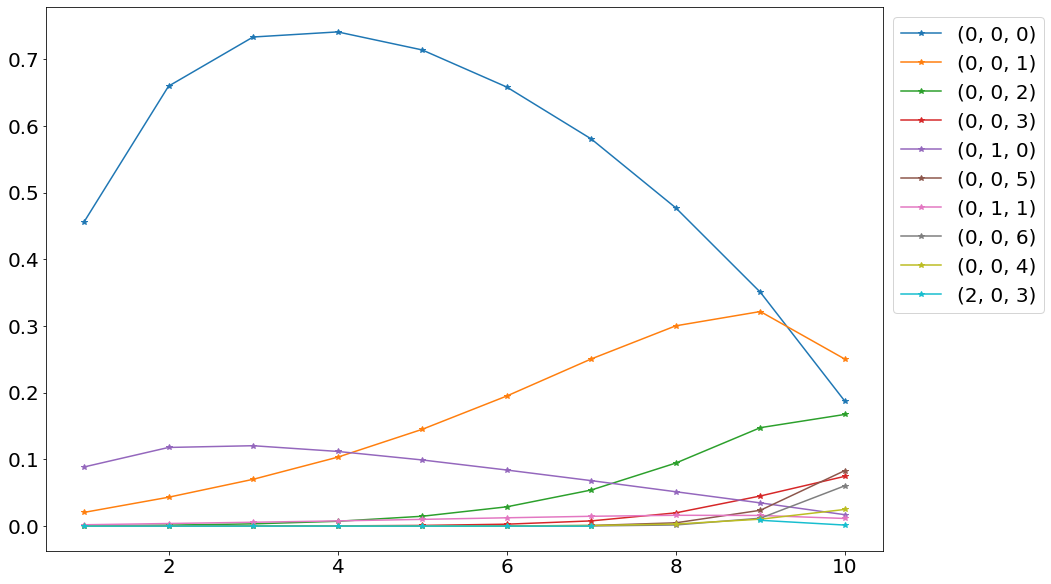

In [13]:
for mut in rising_muts:
    plt.plot(data.loc[mut, 1:], label=mut, marker='*')
plt.legend(bbox_to_anchor=(1,1))

In [14]:
#TODO: wtf with the deleterious mutations appearing after nan?!?

In [19]:
data.loc[(2,0,2)]

0              NaN
1     1.409130e-05
2     4.596895e-06
3     1.152207e-06
4     2.624884e-07
5     5.702374e-08
6     1.185519e-08
7     2.356668e-09
8     4.367375e-10
9              NaN
10    3.136176e-02
Name: (2, 0, 2), dtype: float64

In [20]:
data.loc[(2,1,0)]

0              NaN
1     5.411583e-03
2     7.637927e-04
3     8.282839e-05
4     8.163878e-06
5     7.673259e-07
6     6.901929e-08
7     5.936055e-09
8     4.759461e-10
9              NaN
10    5.350188e-03
Name: (2, 1, 0), dtype: float64

In [17]:
test = data.reset_index()
test['mut_count'] = test[['level_0', 'level_1', 'level_2']].sum(axis=1)
test

,level_0,level_1,level_2,0,1,2,3,4,5,6,7,8,9,10,mut_count
0,0,0,0,1.0,4.561243e-01,6.599684e-01,7.336952e-01,0.741347,7.143219e-01,0.658678,5.807506e-01,0.477352,3.507921e-01,1.872724e-01,0
1,0,0,1,NaN,2.052563e-02,4.329257e-02,7.015887e-02,0.103339,1.451491e-01,0.195106,2.507631e-01,0.300462,3.218676e-01,2.504828e-01,1
2,0,0,2,NaN,4.618277e-04,1.419951e-03,3.354436e-03,0.007202,1.474704e-02,0.028896,5.413868e-02,0.094561,1.476641e-01,1.675144e-01,2
3,0,0,3,NaN,6.927429e-06,3.104863e-05,1.069215e-04,0.000335,9.988588e-04,0.002853,7.792205e-03,0.019840,4.516283e-02,7.468533e-02,3
4,0,0,4,NaN,7.793374e-08,5.091815e-07,2.556067e-06,0.000012,5.074165e-05,0.000211,8.411518e-04,0.003122,1.035974e-02,2.497351e-02,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,9,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.644720e-09,NaN,12
750,9,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.959015e-10,17
751,10,0,0,NaN,8.271458e-10,NaN,2.742173e-09,NaN,1.295367e-09,NaN,3.579569e-09,NaN,3.277427e-09,NaN,10
752,10,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.116213e-09,NaN,NaN,4.542311e-10,11


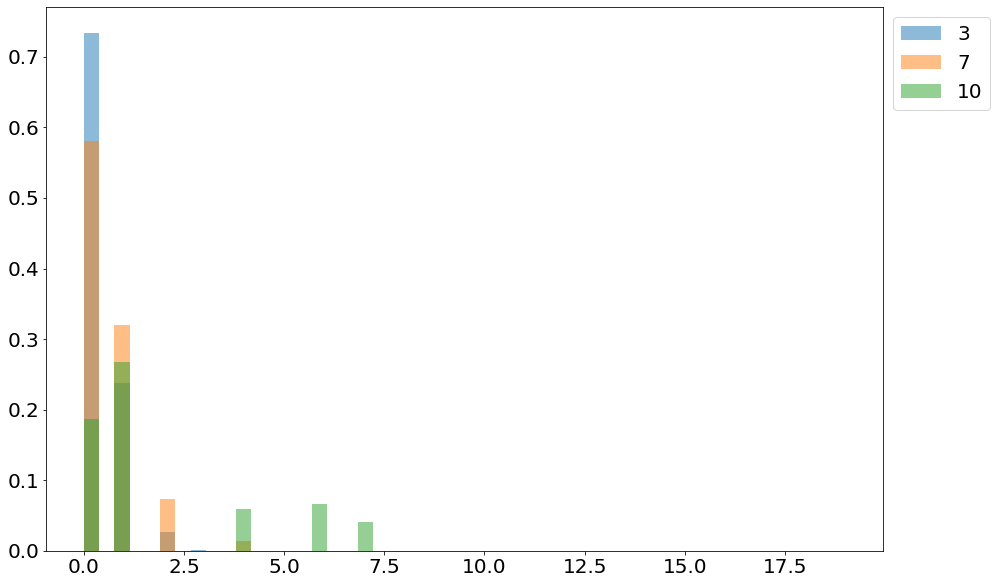

In [18]:
plt.hist(test['mut_count'], weights=test[3], bins=50, alpha=0.5, label=3)
plt.hist(test['mut_count'], weights=test[7], bins=50, alpha=0.5, label=7)
plt.hist(test['mut_count'], weights=test[10], bins=50, alpha=0.5, label=10)
plt.legend(bbox_to_anchor=(1,1))